## Вступление

**Описание**
Допустим, мы работаем в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину. 
Шаги для выбора локации обычно такие:
* В избранном регионе собирают характеристики для скважин: качество нефти и объём её запасов;
* Строят модель для предсказания объёма запасов в новых скважинах;
* Выбирают скважины с самыми высокими оценками значений;
* Определяют регион с максимальной суммарной прибылью отобранных скважин.
Нам предоставлены пробы нефти в трёх регионах. Характеристики для каждой скважины в регионе уже известны.

**Цель:** Построить модель для определения региона, где добыча принесёт наибольшую прибыль. Проанализировать возможную прибыль и риски техникой Bootstrap

**План действий:**

1. Загрузить и подготовить данные. Пояснить порядок действий.
2. Обучить и проверить модель для каждого региона:

    2.1. Разбить данные на обучающую и валидационную выборки в соотношении 75:25.
    
    2.2. Обучить модель и сделать предсказания на валидационной выборке.
    
    2.3. Сохранить предсказания и правильные ответы на валидационной выборке.
    
    2.4. Напечатать на экране средний запас предсказанного сырья и RMSE модели.
    
    2.5. Проанализировать результаты.
3. Подготовиться к расчёту прибыли:

    3.1. Все ключевые значения для расчётов сохранить в отдельных переменных.
    
    3.2. Рассчитать достаточный объём сырья для безубыточной разработки новой скважины. Сравнить полученный объём сырья со средним запасом в каждом регионе. 
    
    3.3. Написать выводы по этапу подготовки расчёта прибыли.
4. Написать функцию для расчёта прибыли по выбранным скважинам и предсказаниям модели:

    4.1. Выбрать скважины с максимальными значениями предсказаний.
    
    4.2. Просуммировать целевое значение объёма сырья, соответствующее этим предсказаниям.
    
    4.3. Рассчитать прибыль для полученного объёма сырья.
5. Посчитать риски и прибыль для каждого региона:

    5.1. Применить технику Bootstrap с 1000 выборок, чтобы найти распределение прибыли.
    5.2. Найти среднюю прибыль, 95%-й доверительный интервал и риск убытков. Убыток — это отрицательная прибыль.
    5.3. Написать выводы: предложить регион для разработки скважин и обосновать выбор.

## 1.Загрузка и подготовка данных

In [1]:
# Добавляем все необходимые библиотеки
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.utils import shuffle

In [2]:
BUDGET = 10 * 10 ** 9
NUMBER_OF_WELLS = 200
COST_1000_BARRELS = 4.5 * 10 ** 5

In [3]:
# открываем и чекаем исходный датасет
try:
    geo_0 = pd.read_csv('geo_data_0.csv')
    geo_1 = pd.read_csv('geo_data_1.csv')
    geo_2 = pd.read_csv('geo_data_2.csv')
except FileNotFoundError:
    geo_0 = pd.read_csv('/datasets/geo_data_0.csv')
    geo_1 = pd.read_csv('/datasets/geo_data_1.csv')
    geo_2 = pd.read_csv('/datasets/geo_data_2.csv')

In [4]:
print(geo_0.info())
print(geo_1.info())
print(geo_2.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column  

Видим, что данные прекрасны. Пропусков нет. Типы данных для каждого признака установлены вполне логично. Полагаю, что колонка с id скажин нам особо не нужна, но прям удалять из дф пока не будем. При разбивке данных просто не учтем эту колонку.

In [5]:
geo_0['id'].duplicated().sum()

10

In [6]:
geo_1['id'].duplicated().sum()

4

In [7]:
geo_2['id'].duplicated().sum()

4

Обнаржули прямые дубликаты по признаку id. В целом некритично, потому что этот признак для нас не носит какойто важности, и дубликатов не так много, если оценивать процентное содержание от размера по каждому региону. Поэтому думаю можно их удалить без опасений.

In [8]:
geo_0.drop_duplicates(subset=['id'], inplace=True)
# geo_0.info()
geo_1.drop_duplicates(subset=['id'], inplace=True)
geo_2.drop_duplicates(subset=['id'], inplace=True)

Удалили дубликаты по признаку id во всех регионах

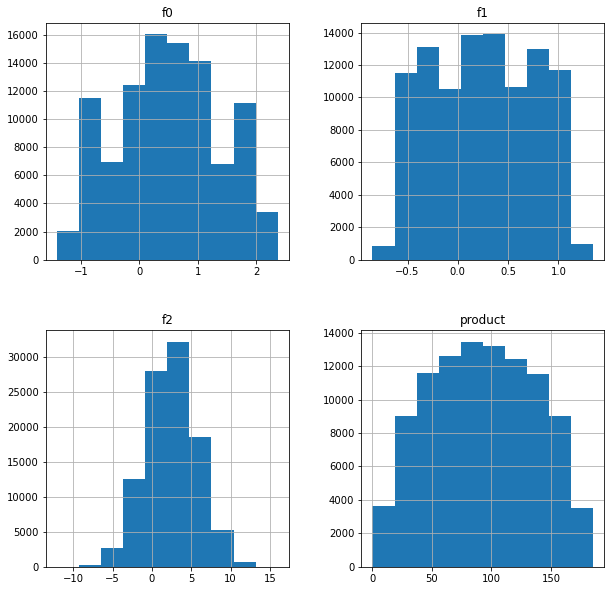

In [9]:
geo_0.hist(bins=10, figsize=(10,10))
plt.show()

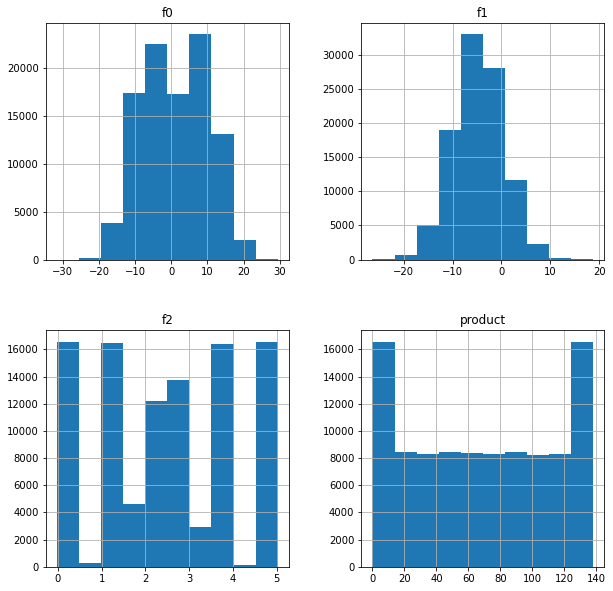

In [10]:
geo_1.hist(bins=10, figsize=(10,10))
plt.show()

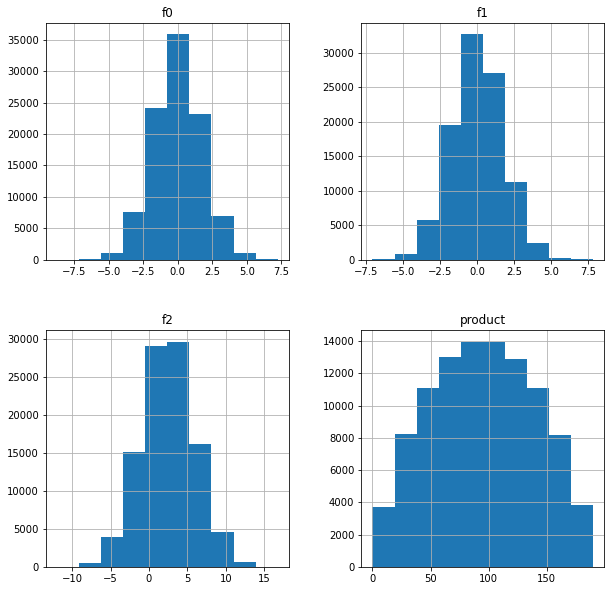

In [11]:
geo_2.hist(bins=10, figsize=(10,10))
plt.show()

По гистограммам распределния количественных признаков видим, что в большинстве своем данные рапсрделены нормально. Кроме 2ого региона, где и переменная f2 и product распрделены уже ненормлаьно.

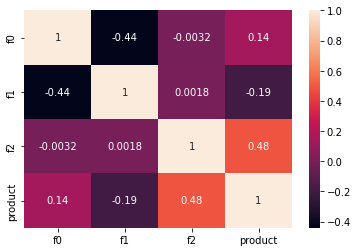

In [12]:
sns.heatmap(geo_0.corr(), annot=True)
plt.show()

По матрице корреляции (хитмапу) видим, что наша целевая переменная достаточно сильно и положительно (прямопропорционально коррелирует с признаком f2). а с двумя другими коррелирует очень слабо, а с одной из них даже практически обратно попрорционально.

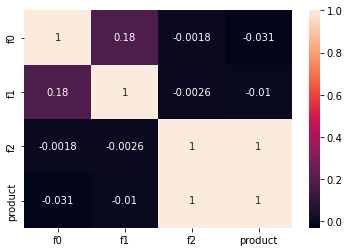

In [13]:
sns.heatmap(geo_1.corr(), annot=True)
plt.show()

По 2ому региону: дико сильная прямопропорциональная корреляция идет между целевой переменной и признаком f2. С остальными признаками практичеки отсутствует корреляция и она склонна к обратной пропорциональности.

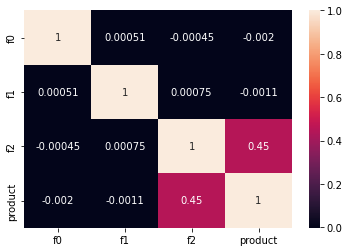

In [14]:
sns.heatmap(geo_2.corr(), annot=True)
plt.show()

По 3ьему региону: картина схожа с первым регионом. просматривается хорошая прямая корреляция целевой переменной с третьим признаком. а с остальными двумя практически отсутствует корреляция.

## 2. Обучение и проверка моделей для каждого региона

Сначала нужно во всех данных разбить данные.

In [15]:
def splitter(data):
    # Разделим выборку на валидационную и тестовую. 
    # Так как необходимо соотношение 75:25 обучающая валидационная, и при этом еще надо выделить тестовую,
    # То итоговое соотношение получится 50:25:25
    data_train, data_test = train_test_split(data, test_size=0.5, random_state=12345)
    data_test, data_valid = train_test_split(data_test, test_size=0.5, random_state=12345)

    #  Определим зависимую и независимые переменные для выделенных датасетов
    X_train = data_train.drop(['id', 'product'], axis=1)
    Y_train = data_train['product']
    X_valid = data_valid.drop(['id', 'product'], axis=1)
    Y_valid = data_valid['product']
    X_test = data_test.drop(['id', 'product'], axis=1)
    Y_test = data_test['product']
    
    # Нормализуем данные
    numeric = ['f0', 'f1', 'f2']
    scaler = StandardScaler()
    scaler.fit(X_train[numeric])

    X_train[numeric] = scaler.transform(X_train[numeric])
    X_valid[numeric] = scaler.transform(X_valid[numeric])
    X_test[numeric] = scaler.transform(X_test[numeric])
    
    return X_train, Y_train, X_valid, Y_valid, X_test, Y_test

In [16]:
# Разбиваем данные по нашим трем дф

X_train_0, Y_train_0, X_valid_0, Y_valid_0, X_test_0, Y_test_0 = splitter(geo_0)
# print(X_test_0.shape)
# print(Y_test_0.shape)
X_train_1, Y_train_1, X_valid_1, Y_valid_1, X_test_1, Y_test_1 = splitter(geo_1)
X_train_2, Y_train_2, X_valid_2, Y_valid_2, X_test_2, Y_test_2 = splitter(geo_2)

### Находим лучшую модель по geo_0

Так как характер всех 3 геоданных у нас одинаквый: три параметра и количество нефти, то в целях экономии времени можно попробовать пойти по такому пути: возьмем первый набор данных, определим алгоритм, что даст нам наилучший результат по метркие rmse и будем использовать этот алгоритм для двух оставшихся геоданных.

In [17]:
# Создадим словарь для записи наилучшей модели, результатво и параметров
sl_0 = {}

In [18]:
geo_0['product'].mean()

92.49968421774328

#### Дерево решений

In [19]:
# Перебираем гиперпараметры и выбираем модель с минимальным значением RMSE

best_rmse = 1000000
best_valid = 0
good_tree = None
for depth in range(1,7):
    for split in range(2,4):
        for leaf in range(1,6):
            model = DecisionTreeRegressor(max_depth=depth, 
                                           min_samples_split=split, 
                                           min_samples_leaf=leaf,
                                           random_state=12345)
            model.fit(X_train_0, Y_train_0)
            pred_valid = model.predict(X_valid_0)
            rmse = mean_squared_error(Y_valid_0, pred_valid) ** 0.5
            if rmse < best_rmse:
                best_valid = pred_valid
                best_rmse = rmse
                best_params = {'max_depth': depth, 'min_samples_split': split, 'min_samples_leaf': leaf}
                good_tree = model

print(best_rmse)                
print(best_params)
sl_0['Decision Tree'] = [best_rmse, best_params, good_tree]


37.650580251652094
{'max_depth': 6, 'min_samples_split': 2, 'min_samples_leaf': 5}


Получили, что на алгоритме "Дерево решений", наименьшее значение RMSE составило 37.7, это означает, что предсказания нашей модели отличаются от фактических на 37 тысяч баррелей.

#### Случайный лес

In [20]:
best_rmse = 1000000
best_valid = 0
good_forest = None
for est in range(10,31,10):
    for depth in range(1, 5):
        for split in range(2,3):
            for leaf in range(1,2):
                model = RandomForestRegressor(n_estimators=est,
                                               min_samples_split=split,
                                               max_depth=depth,
                                               min_samples_leaf=leaf,
                                               random_state=12345)
                model.fit(X_train_0, Y_train_0)
                pred_valid = model.predict(X_valid_0)
                rmse = mean_squared_error(Y_valid_0, pred_valid) ** 0.5
                if rmse < best_rmse:
                    best_valid = pred_valid
                    best_rmse = rmse
                    best_params = {'n_estimators': est, 'max_depth': depth, 
                                   'min_samples_split': split, 'min_samples_leaf': leaf}
                    good_forest = model

print(best_rmse)
print(best_params)
sl_0['Random Forest'] = [best_rmse, best_params, good_tree]


37.71168616956792
{'n_estimators': 20, 'max_depth': 4, 'min_samples_split': 2, 'min_samples_leaf': 1}


Получили, что на алгоритме "Случайного леса", наименьшее значение RMSE составило тоже 37.7, это означает, что предсказания нашей модели отличаются от фактических на 37 тысяч баррелей.

#### Классическая линейная регрессия

In [21]:
model_0 = LinearRegression()
model_0.fit(X_train_0, Y_train_0)
pred_valid = model_0.predict(X_valid_0)
rmse = mean_squared_error(Y_valid_0, pred_valid) ** 0.5
print(rmse)

sl_0['Linear Regression'] = [rmse, model_0]


37.6999520447097


Получили, что на алгоритме "Линейная регрессия", наименьшее значение RMSE составило 37.6, это означает, что предсказания нашей модели отличаются от фактических на 36 тысяч баррелей.

Определим точного победителя, чтобы понять какой алгорит выберем для предсказаний.

In [22]:
max_key = min(sl_0.items(), key=lambda x: x[1][0])[0]
print(max_key)
print('RMSE = ', sl_0[max_key][0])

Decision Tree
RMSE =  37.650580251652094


В целом и так было понятно, что наилучшим алгоритмом дла геоданных_0 оказалась линейная регрессия. Значит используем ее для остальных геоданных

Сохраним результаты в отдельный словарь.

In [23]:
sl_rmse = {'RMSE 0': sl_0[max_key][0]}

### Обучение моделей для geo 1 и 2

Обучим модель и определим RMSE для двух оставшихся дф

In [24]:
# geo_1
model_1 = LinearRegression()
model_1.fit(X_train_1, Y_train_1)
pred_valid = model_1.predict(X_valid_1)
rmse = mean_squared_error(Y_valid_1, pred_valid) ** 0.5
print(rmse)

sl_rmse['RMSE 1'] =  rmse

# geo_2
model_2 = LinearRegression()
model_2.fit(X_train_2, Y_train_2)
pred_valid = model_2.predict(X_valid_2)
rmse = mean_squared_error(Y_valid_2, pred_valid) ** 0.5
print(rmse)

sl_rmse['RMSE 2'] =  rmse

0.8917355955898417
40.20390610085968


In [25]:
print(sl_rmse)

{'RMSE 0': 37.650580251652094, 'RMSE 1': 0.8917355955898417, 'RMSE 2': 40.20390610085968}


Здесь мы мжем видеть, что метрика RMSE для геоданных_1 оказалась самой наилучшей. "отклонение" меньше тысячи баррелей. А вот у геоданных_2 наоборот получилось самое высокое отклонение - 40 тысяч.

### Прогнозирвоание значений на тестовых выборках для geo 0, 1 и 2

In [26]:
sl_test_rmse = {'Признак': ['mean', 'RMSE']}

In [27]:
# geo_0
pred_test_0 = model_0.predict(X_test_0)
rmse = mean_squared_error(Y_test_0, pred_test_0) ** 0.5
print(rmse)

sl_test_rmse['GEO 0'] =  [pred_test_0.mean(), rmse]

# geo_1
pred_test_1 = model_1.predict(X_test_1)
rmse = mean_squared_error(Y_test_1, pred_test_1) ** 0.5
print(rmse)

sl_test_rmse['GEO 1'] =  [pred_test_1.mean(), rmse]

# geo_2
pred_test_2 = model_2.predict(X_test_2)
rmse = mean_squared_error(Y_test_2, pred_test_2) ** 0.5
print(rmse)

sl_test_rmse['GEO 2'] =  [pred_test_2.mean(), rmse]



37.94881451095149
0.8927318082354637
39.88366654606752


In [28]:
sl_test_rmse_df = pd.DataFrame(sl_test_rmse)
print(sl_test_rmse_df)

  Признак      GEO 0      GEO 1      GEO 2
0    mean  92.804192  68.694101  95.073656
1    RMSE  37.948815   0.892732  39.883667


## 3. Подготовка к расчёту прибыли

In [29]:
min_volume = BUDGET / (NUMBER_OF_WELLS * COST_1000_BARRELS)
print(min_volume)

if min_volume < geo_0['product'].mean():
    print('good 0')
if min_volume < geo_1['product'].mean():
    print('good 1')
if min_volume < geo_2['product'].mean():
    print('good 2')
    
# len(geo_0[geo_0['product'] > min_volume])
# print(geo_0['product'].mean())

111.11111111111111


Получили минимальный объём сырья для безубыточной разработки - 111.11 тысяч баррелей. А так же посчитали, что среднее значение по объему нефти в скажинах меньше чем минимальный объём безубыточности.

## 4. Функция для расчёта прибыли по выбранным скважинам и предсказаниям модели

In [30]:
#ячейка ревьюера

def profit_calc(predict, target):
    ''' сортируем предсказания'''
    predict_sorted = predict.sort_values(ascending=False)
    ''' берем соответствующие им по индексам реальные значения'''    
    target_sorted = target[predict_sorted.index][:NUMBER_OF_WELLS]    
    product = target_sorted.sum()
    
    ''' выражаем прибыль в млн'''
    return (product * COST_1000_BARRELS - BUDGET)/1e6 

Создали функцию для расчета прибыли.

## 5. Расчитаем риски и прибыль для каждого региона:

In [31]:
#ячейка ревьюера
'''индексы НЕ соответствуют'''

Y_test_0, pred_test_0

(10947    153.487265
 75137    161.033006
 52206     49.339484
 9236     132.377556
 71482     12.232629
             ...    
 28079    123.771630
 14895    144.495987
 65848    136.184531
 6583     101.596316
 64478     39.903187
 Name: product, Length: 24997, dtype: float64,
 array([122.40321726, 128.91574615,  82.9548382 , ...,  97.16413993,
        103.44270722,  96.69422009]))

In [32]:
#ячейка ревьюера
'''индексы соответствуют'''

Y_test_0, pd.Series(pred_test_0, Y_test_0.index)

(10947    153.487265
 75137    161.033006
 52206     49.339484
 9236     132.377556
 71482     12.232629
             ...    
 28079    123.771630
 14895    144.495987
 65848    136.184531
 6583     101.596316
 64478     39.903187
 Name: product, Length: 24997, dtype: float64,
 10947    122.403217
 75137    128.915746
 52206     82.954838
 9236     109.650171
 71482     33.883785
             ...    
 28079    100.416487
 14895    102.207552
 65848     97.164140
 6583     103.442707
 64478     96.694220
 Length: 24997, dtype: float64)

Смэтчим индексы предсказаний и таргетов.

In [33]:
pred_test_0 = pd.Series(pred_test_0, Y_test_0.index)
pred_test_1 = pd.Series(pred_test_1, Y_test_1.index)
pred_test_2 = pd.Series(pred_test_2, Y_test_2.index)


In [34]:
# Создаем функцию для техники Bootstrap для расчета прибыли
# def bootstrap(target, predictions, n_samples):
#     values = []
#     state = np.random.RandomState(12345)
#     for i in range(n_samples):
#         target_sampled = np.random.choice(target, size=len(target), replace=True)
#         preds_sampled = np.random.choice(predictions, size=len(predictions), replace=True)
#         values.append(profit_calc(preds_sampled, target_sampled))
#     return values

def bootstrap(target, predictions, n_samples):
    values = []
    state = np.random.RandomState(12345)
    for i in range(n_samples):
        ''' нам надо выбрать 500 случайных значений из таргета'''
        target_500 = target.sample(500, replace=True, random_state=state) 
        ''' берем соответствующие им по индексам предсказания'''
        predict_500 = predictions[target_500.index]
        values.append(profit_calc(predict_500, target_500)) 
    ''' получили 1000 вариантов (значений) прибыли'''
    return pd.Series(values)


In [35]:
n_samples = 1000

# Вычисляем распределение прибыли для каждого региона
v_0 = bootstrap(Y_test_0, pred_test_0, n_samples)
v_1 = bootstrap(Y_test_1, pred_test_1, n_samples)
v_2 = bootstrap(Y_test_2, pred_test_2, n_samples)

#print(v_0)

In [36]:
# Рассчитываем среднюю прибыль
mean_profit_0 = np.mean(v_0)
mean_profit_1 = np.mean(v_1)
mean_profit_2 = np.mean(v_2)

In [37]:
# Определяем доверительный интервал
interval_0 = np.percentile(v_0, [2.5, 97.5])
interval_1 = np.percentile(v_1, [2.5, 97.5])
interval_2 = np.percentile(v_2, [2.5, 97.5])

In [38]:
# Расчитываем риск убытков
risk_0 = np.mean(np.array(v_0) < 0)
risk_1 = np.mean(np.array(v_1) < 0)
risk_2 = np.mean(np.array(v_2) < 0)


In [39]:
# Выводим результаты
print("Средняя прибыль региона 0:", mean_profit_0)
print("95%-й доверительный интервал региона 0:", interval_0)
print("Риск убытков региона 0:", risk_0)

print("Средняя прибыль региона 1:", mean_profit_1)
print("95%-й доверительный интервал региона 1:", interval_1)
print("Риск убытков региона 1:", risk_1)

print("Средняя прибыль региона 2:", mean_profit_2)
print("95%-й доверительный интервал региона 2:", interval_2)
print("Риск убытков региона 2:", risk_2)

Средняя прибыль региона 0: 451.89966267159934
95%-й доверительный интервал региона 0: [-40.66247331 966.52062702]
Риск убытков региона 0: 0.039
Средняя прибыль региона 1: 517.5442578159368
95%-й доверительный интервал региона 1: [ 80.11429022 943.18207005]
Риск убытков региона 1: 0.01
Средняя прибыль региона 2: 383.31712733143024
95%-й доверительный интервал региона 2: [-169.03848525  940.5055776 ]
Риск убытков региона 2: 0.087


## Вывод

По условию посталвенной задачи, нам необходимо выбрать тот регион, в котором будет макисмаьная прибыль и минимальные риски. ПРитом есть четкий порог по допустимости рисокв - 2.5%.

In [40]:
print('Allowed geo_0' if risk_0 < 2.5 / 100 else 'Not allowed geo_0')
print('Allowed geo_1' if risk_1 < 2.5 / 100 else 'Not allowed geo_1')
print('Allowed geo_2' if risk_2 < 2.5 / 100 else 'Not allowed geo_2')

Not allowed geo_0
Allowed geo_1
Not allowed geo_2


Из полученных результатов видим, что после прохода порога на минимальные риски подходит только регион 2. Ожидаемая прибыль региона варьируется от 80 до 943 млн рублей.

## Общий вывод

1. Были изучены предоставленные данные. В каждом регионе было найдено по несколько дубликатов айди скважин. Дубликаты бли исключены из выборок. Изучили распределение количественных признаков, а так же провели исследование на корреляцию количественных признаков с целевым признаком.
2. По каждому региону разбили выборки на обучающую, валидационну и тестовую в соотношении 2:1:1. По первому региону построили 3 модели линейной регрессии (алгорит решающего дерева, случайного леса и линейной регрессии) и по метрике rmse выбрали самую наилучшую модель. А если точнее, то выбралась модель, у которой rmse на валидационной выборке был минимальный - это была линейная регрессия со значением rmse = 37.7 тыс баррелей. 
3. Используя тот же алгоритм обучили модель для второго и третьего региона. Получили значения rmse соотвественно 0.9 и 40.2.
4. Применили полученные модели к тестовым выборкам и получили спрогнозированные данные. Метрика rmse по каждой составила 37.9, 0.9 и 39.9 соответственно.
5. Рассчитали минимальный объем нефти, который должен быть в каждой из 200 скважин. Получилось 111.11 тысяч баррелей нефти.
6. Написали функцию profit_calc, которая рассчитывает прибыль по заданным 200 скважинами и предсказаниям модели.
7. Написали функцию для техники bootstrap для расчета прибыли. Рассчитали распределение прибыли для каждого региона. 
8. Рассчитали среднюю прибыль каждого региона. Рассчитали 95%-й доверительный интервал и рассчитали риск убытков так же для каждого региона.
9. Определили регион с минимальным риском и максимальной прибылью. Это скважины 2ого региона. Риск безубыточности - 1% а интервал возможной прибыли составляет от 80 до 943млн рублей.